In [62]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
rule = '3T'
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)

df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df.index.map(lambda x: x.hour)
df.columns = ['date', 'time', 'open', 'high', 'low','close','volume','hour']
Morning = df[(df['hour'] >= 8) & (df['hour'] <= 13)]
Morning.index += dt.timedelta(minutes=15) # 往前調整15mins
Morning.resample(rule=rule, closed='right', label='right').first()[['open']].iloc[0:3]

rule = '60T'
Morning = df[(df['hour'] >= 8) & (df['hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]
df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)

Night = df[(df['hour'] < 8) | (df['hour'] > 13)]
d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]
df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()

df_Day = pd.concat([df_Morning, df_Night], axis=0) #先日再夜
df_Day = df_Day.sort_index(ascending=True) #按照時間
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2018-12-31 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2019-1-1 00:00:00')].copy()
settlementDate_ = pd.read_csv('settlementDate.csv') #, encoding = 'ANSI'
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']] # if第三周->true, else: false
settlementDate = [pd.to_datetime(i).date() for i in list(settlementDate_[bool_]['settlementDate'])] #擷取第三個禮拜的日期資料


In [63]:
df = trainData.copy()

In [64]:
df.tail(5)

,open,high,low,close,volume,Hour
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12


In [65]:
fund = 1000000
FEE = 600
LENGTH = 20
NUMSTD = 1.5
K = 0.04 # 若漲跌大於4%，則止盈止損

# 策略01: 布林通道

In [66]:
df['MA'] = df['close'].rolling(window=LENGTH, center=False).mean()
df['STD'] = df['close'].rolling(window=LENGTH, center=False).std()
df['upLine'] = df['MA'] + NUMSTD*df['STD'] #布林通道上軌
df['downLine'] = df['MA'] - NUMSTD*df['STD'] #布林通道下軌
df.tail()

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,9549.65,77.077729,9665.266594,9434.033406
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,9552.00,79.717924,9671.576886,9432.423114
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,9554.15,81.996967,9677.145451,9431.154549
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,9556.90,84.977954,9684.366931,9429.433069
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,9559.45,87.692930,9690.989395,9427.910605


In [67]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)

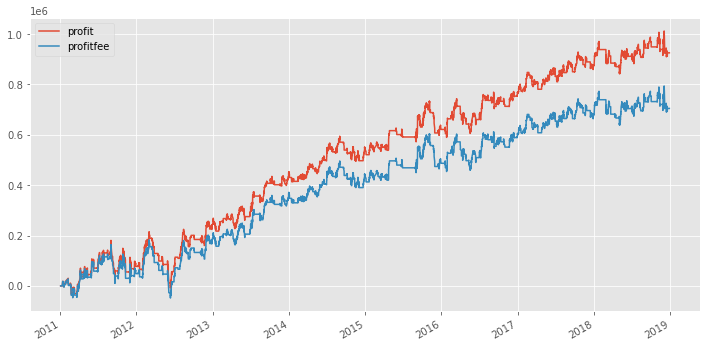

In [68]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = df_arr[i,3] > df_arr[i,8]
    entryCondition = date_arr[i] not in settlementDate
    exitShort = df_arr[i,3] < df_arr[i,9]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-Kdown) #比進場價格少了4%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+Kup) #比進場價格多了4%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

# 策略02: 肯特納通道

In [69]:
df = trainData.copy()


In [70]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)


In [73]:
"""
ATR指標全名為Average True Range(真實價格區間)，指的是股價真實的波動幅度。
其算法是先計算每天的TR(True Range)，再以EMA（指數移動平均）之方式計算N日TR平均值以取得ATR。
TR的算法如下：TRt = max((Ht – Lt),abs(Ct-1 – Ht), abs(Ct-1 – Lt))
以EMA計算ATR，將TR做趨勢平滑，讓指標不易有暴起暴落的雜訊
"""
#做多
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    if i==0:
        lastTRt = 0
        lastEMA = 0
    max_min = df_arr[i,1] - df_arr[i,2] # 當日高低價之差額
    cl_max = abs(df_arr[i-1,3] - df_arr[i,1]) # 前日收盤與當日最高價之差額
    cl_min = abs(df_arr[i-1,3] - df_arr[i,2]) # 前日收盤與當日最低價之差額
    TRt = max(max_min, cl_max, cl_min) #有疑慮 一些人說的不一樣 - min(max_min, cl_max, cl_min)
    ATR = TRt*(2/21) + lastTRt*(19/21) #10日或20日
    EMA20 = df_arr[i,3]*(2/21) + lastEMA*(19/21)
    upline = EMA20+2*ATR
    downline = EMA20-2*ATR

    entryLong = df_arr[i,3] > upline
    entryCondition = date_arr[i] not in settlementDate
    exitShort = df_arr[i,3] < downline
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K) #比進場價格少了4%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K) #比進場價格多了4%

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);
    lastTRt = TRt
    lastEMA = EMA20

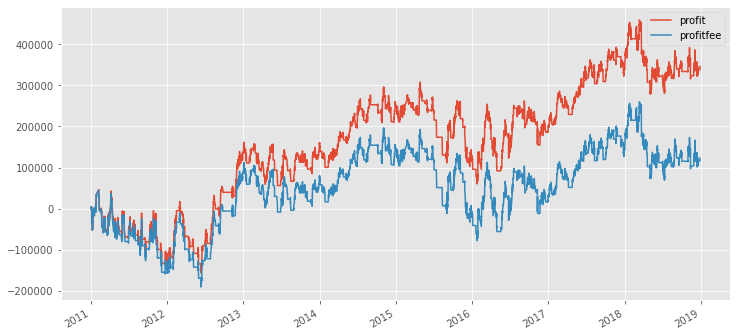

In [74]:
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
# print(equity)
equity.plot(grid=True, figsize=(12,6));

# 策略03 kd指標

In [84]:
df = trainData.copy()

In [85]:
def calculate_kd(df, n=9, m=3):
    df['lowest_low'] = df['low'].rolling(n).min()
    df['highest_high'] = df['high'].rolling(n).max()
    df['rsv'] = (df['close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low']) * 100
    df['K'] = df['rsv'].ewm(span=m).mean()
    df['D'] = df['K'].ewm(span=m).mean()
calculate_kd(df)
df.tail(10)

,open,high,low,close,volume,Hour,lowest_low,highest_high,rsv,K,D
2018-12-27 08:45:00,9589.0,9604.0,9566.0,9575.0,38472,8,9426.0,9604.0,83.707865,60.514740,51.048327
2018-12-27 09:45:00,9575.0,9616.0,9571.0,9598.0,27280,9,9438.0,9616.0,89.887640,75.201190,63.124758
2018-12-27 10:45:00,9597.0,9648.0,9594.0,9645.0,24059,10,9438.0,9648.0,98.571429,86.886309,75.005534
2018-12-27 11:45:00,9645.0,9655.0,9641.0,9652.0,10503,11,9438.0,9655.0,98.617512,92.751910,83.878722
2018-12-27 12:45:00,9653.0,9653.0,9615.0,9633.0,23781,12,9438.0,9655.0,89.861751,91.306831,87.592777
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,9438.0,9660.0,92.792793,92.049812,89.821294
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,9438.0,9666.0,96.491228,94.270520,92.045907
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,9438.0,9666.0,95.614035,94.942278,93.494092
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,9566.0,9671.0,98.095238,96.518758,95.006425
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,9571.0,9680.0,91.743119,94.130939,94.568682


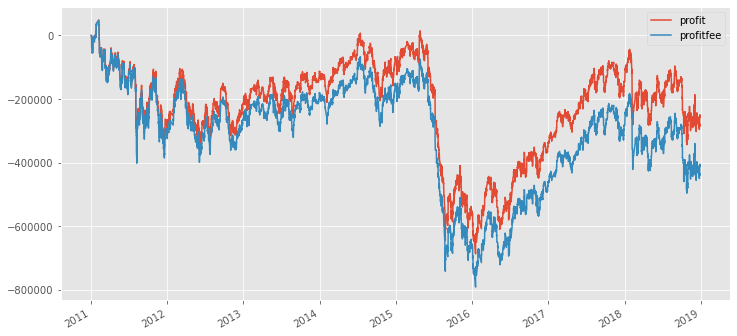

In [86]:
def calculate_kd(df, n=9, m=3):
    df['lowest_low'] = df['low'].rolling(n).min()
    df['highest_high'] = df['high'].rolling(n).max()
    df['rsv'] = (df['close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low']) * 100
    df['K'] = df['rsv'].ewm(span=m).mean()
    df['D'] = df['K'].ewm(span=m).mean()
calculate_kd(df)
df.tail(10)
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)

BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = (df_arr[i,9] >= df_arr[i,10]) and (df_arr[i+1,9] <= df_arr[i+1,10])
    entryCondition = date_arr[i] not in settlementDate
    exitLong = (df_arr[i,9] <= df_arr[i,10]) and (df_arr[i+1,9] >= df_arr[i+1,10])
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05) #5%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05) #5%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

In [87]:
# 策略04 RSI指標

In [88]:
df = trainData.copy()

In [89]:
# plt.figure(figsize=(12, 6))
# plt.plot(df['rsi'], label='RSI')
# plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
# plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
# plt.legend()
# plt.title('RSI')
# plt.grid(True)


In [90]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

# 執行RSI計算
calculate_rsi(df)
df.tail(10)

,open,high,low,close,volume,Hour,rsi
2018-12-27 08:45:00,9589.0,9604.0,9566.0,9575.0,38472,8,46.186441
2018-12-27 09:45:00,9575.0,9616.0,9571.0,9598.0,27280,9,48.478702
2018-12-27 10:45:00,9597.0,9648.0,9594.0,9645.0,24059,10,52.875696
2018-12-27 11:45:00,9645.0,9655.0,9641.0,9652.0,10503,11,52.962963
2018-12-27 12:45:00,9653.0,9653.0,9615.0,9633.0,23781,12,73.333333
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,73.934837
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,77.057357
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,74.386921
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,75.263158
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,71.686747


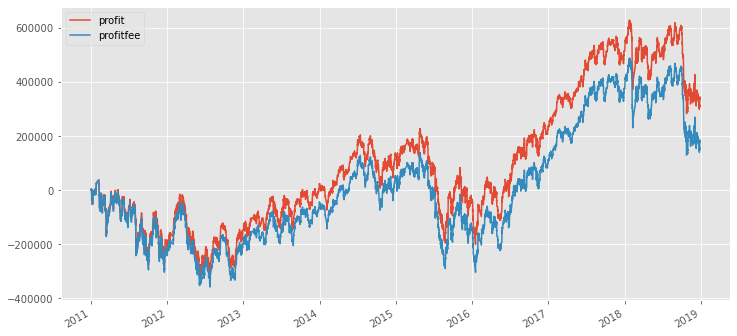

In [92]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)

BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = (df_arr[i,6] >= 30)
    entryCondition = date_arr[i] not in settlementDate
    exitLong = (df_arr[i,6] <= 70)
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05) #5%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05) #5%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

In [ ]:
# 策略05: Momemtum

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


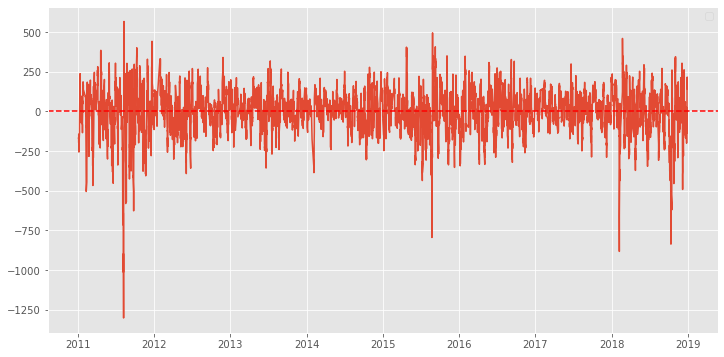

In [94]:
df = trainData.copy()
def calculate_momentum(df, window=14):
    df['momentum'] = df['close'].diff(window)

# 執行動量計算
calculate_momentum(df)

# 繪製動量指標圖
plt.figure(figsize=(12, 6))
plt.plot(df['momentum'])
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
df.tail(10)

,open,high,low,close,volume,Hour,momentum
2018-12-27 08:45:00,9589.0,9604.0,9566.0,9575.0,38472,8,-36.0
2018-12-27 09:45:00,9575.0,9616.0,9571.0,9598.0,27280,9,-15.0
2018-12-27 10:45:00,9597.0,9648.0,9594.0,9645.0,24059,10,31.0
2018-12-27 11:45:00,9645.0,9655.0,9641.0,9652.0,10503,11,32.0
2018-12-27 12:45:00,9653.0,9653.0,9615.0,9633.0,23781,12,182.0
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,191.0
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,217.0
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,179.0
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,192.0
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,144.0


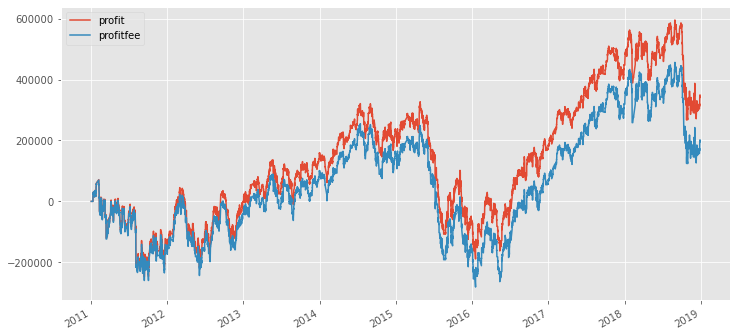

In [96]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = df_arr[i,6] > 0
    entryCondition = date_arr[i] not in settlementDate
    exitShort = df_arr[i,3] < 0
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05) #比進場價格少了4%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05) #比進場價格多了4%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

In [ ]:
# 策略06 突破策略

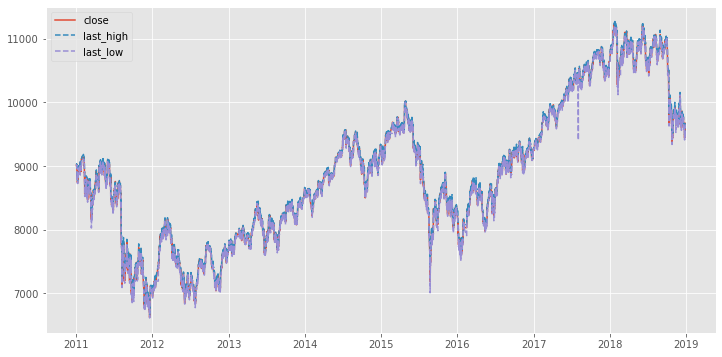

In [107]:
df = trainData.copy()

def calculate_breakout_levels(df, window=2):
    df['prev_high'] = df['high'].rolling(window=window).max()
    df['prev_low'] = df['low'].rolling(window=window).min()

# 執行前一高點和前一低點計算
calculate_breakout_levels(df)

# 繪製收盤價和前一高低點圖
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='close')
plt.plot(df['prev_high'], label='last_high', linestyle='--')
plt.plot( df['prev_low'], label='last_low', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

In [108]:
df.tail(5)

,open,high,low,close,volume,Hour,prev_high,prev_low
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,9660.0,9615.0
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,9666.0,9622.0
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,9666.0,9622.0
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,9671.0,9648.0
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,9680.0,9654.0


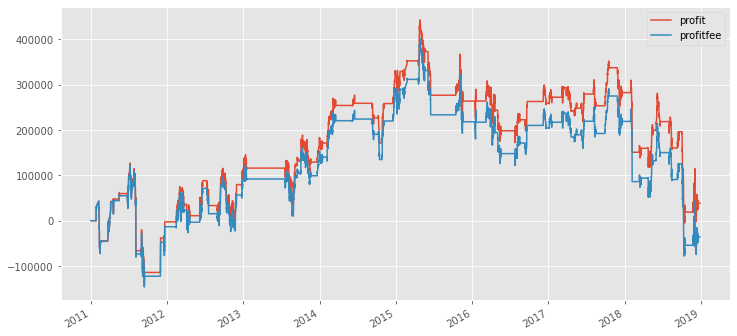

In [109]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)

BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = (df_arr[i,3] >= df_arr[i,6])
    entryCondition = date_arr[i] not in settlementDate
    entryLong = (df_arr[i,3] <= df_arr[i,7])
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11

    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-0.05) #5%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+0.05) #5%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間

    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

In [129]:
df = trainData.copy()
def calculate_macd(df, short_window=8, long_window=60, signal_window=20):
    df['ShortEMA'] = df['close'].ewm(span=short_window, min_periods=1).mean()
    df['LongEMA'] = df['close'].ewm(span=long_window, min_periods=1).mean()
    df['MACD'] = df['ShortEMA'] - df['LongEMA']
    df['SignalLine'] = df['MACD'].ewm(span=signal_window, min_periods=1).mean()

# 執行MACD計算
calculate_macd(df)

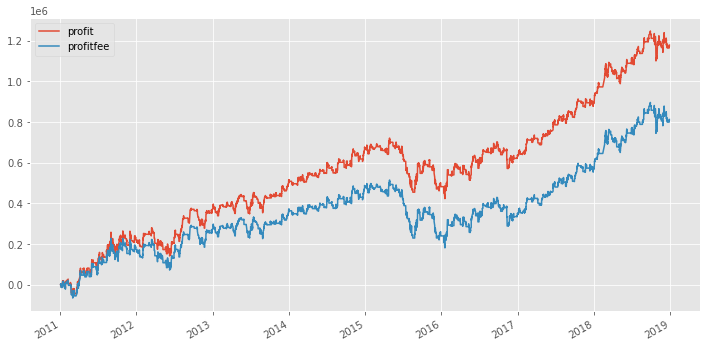

In [130]:
df_arr = np.array(df) # 數據
time_arr = np.array(df.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr] # datetime.date(2011, 2, 8)
BS = None
buy = []
sell = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
for i in range(len(time_arr)):
    if i == len(df_arr)-1:
        break
    entryLong = df_arr[i,8] > df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate
    exitShort = df_arr[i,8] < df_arr[i,9]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-Kdown) #比進場價格少了4%
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+Kup) #比進場價格多了4%
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1 #下一期再買
            buy.append(t) #紀錄進場時間
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0]) #單一期的損益
        profit_list.append(profit)
        if exitShort or exitCondition or stopLoss or stopProfit or i == len(df_arr)-2 :
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0]) #下一期的一開始才結束交易，計算總損益
            profit_fee = profit - FEE*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS = None
            profit_fee_realized = pl_round - FEE*2
            profit_fee_list_realized.append(profit_fee_realized)
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee);

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
equity.plot(grid=True, figsize=(12,6));

In [49]:
def calculate_kd(df, n=9, m=3):
    df['lowest_low'] = df['low'].rolling(n).min()
    df['highest_high'] = df['high'].rolling(n).max()
    df['rsv'] = (df['close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low']) * 100
    df['K'] = df['rsv'].ewm(span=m).mean()
    df['D'] = df['K'].ewm(span=m).mean()
def backtest(df):
    df['signal'] = 0
    df.loc[(df['K'] > df['D']) & (df['K'].shift(1) <= df['D'].shift(1)), 'signal'] = 1  # 買入信號
    df.loc[(df['K'] < df['D']) & (df['K'].shift(1) >= df['D'].shift(1)), 'signal'] = -1  # 賣出信號
calculate_kd(df)
backtest(df)

In [50]:
df['returns'] = df['close'].pct_change() * df['signal'].shift(1)
total_returns = (df['returns'] + 1).cumprod()
total_returns.iloc[0] = 1  # 設置初始值為1
df['total_returns'] = total_returns

In [51]:
df.tail(5)

,open,high,low,close,volume,Hour,lowest_low,highest_high,rsv,K,D,signal,returns,total_returns
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,9438.0,9660.0,92.792793,92.049812,89.821294,0,0.0,0.956679
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,9438.0,9666.0,96.491228,94.270520,92.045907,0,0.0,0.956679
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,9438.0,9666.0,95.614035,94.942278,93.494092,0,-0.0,0.956679
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,9566.0,9671.0,98.095238,96.518758,95.006425,0,0.0,0.956679
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,9571.0,9680.0,91.743119,94.130939,94.568682,-1,0.0,0.956679


C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

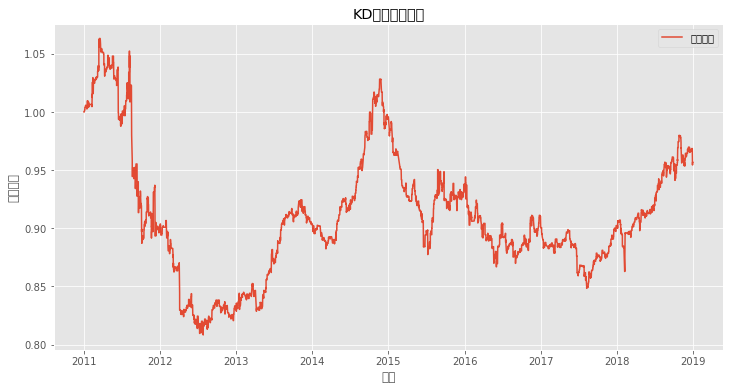

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(df['total_returns'], label='策略收益')
plt.legend()
plt.title('KD策略收益曲線')
plt.xlabel('小時')
plt.ylabel('累計收益')
plt.grid(True)

plt.show()

In [ ]:
fast_ma_window = 10
slow_ma_window = 50

trainData['fast_ma'] = trainData['close'].rolling(fast_ma_window).mean()
trainData['slow_ma'] = trainData['close'].rolling(slow_ma_window).mean()

In [2]:
# fund = 1000000
# FEE = 600
# LENGTH = 20
# NUMSTD = 1.53
# Kup = 0.04
# Kdown= 0.04
# trainData['MA'] = trainData['close'].rolling(window=LENGTH, center=False).mean()
# trainData['STD'] = trainData['close'].rolling(window=LENGTH, center=False).std()
# trainData['upLine'] = trainData['MA'] + NUMSTD*trainData['STD'] #布林通道上軌
# trainData['downLine'] = trainData['MA'] - NUMSTD*trainData['STD'] #布林通道下軌

In [13]:


# 初始化相關變數
position = 0
buy_price = 0
sell_price = 0
buy_signal = False
sell_signal = False
profit_list = []

# 計算快速和慢速移動平均線


C:\Users\user\AppData\Local\Temp\ipykernel_1988\63627812.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData2['fast_ma'] = trainData2['close'].rolling(fast_ma_window).mean()
C:\Users\user\AppData\Local\Temp\ipykernel_1988\63627812.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData2['slow_ma'] = trainData2['close'].rolling(slow_ma_window).mean()


In [15]:
trainData2.tail()

,open,high,low,close,volume,Hour,fast_ma,slow_ma
2018-12-28 08:45:00,9630.0,9660.0,9625.0,9644.0,31047,8,9570.9,9632.10
2018-12-28 09:45:00,9644.0,9666.0,9622.0,9658.0,25826,9,9586.1,9629.40
2018-12-28 10:45:00,9656.0,9661.0,9648.0,9656.0,9574,10,9600.6,9626.74
2018-12-28 11:45:00,9657.0,9671.0,9654.0,9669.0,8113,11,9618.9,9624.32
2018-12-28 12:45:00,9669.0,9680.0,9660.0,9671.0,18247,12,9640.1,9621.94


In [17]:

for i in range(len(df) - 1):
    # 檢查是否有交叉信號
    if trainData2['fast_ma'][i] > trainData2['slow_ma'][i] and trainData2['fast_ma'][i - 1] <= trainData2['slow_ma'][i - 1]:
        buy_signal = True
    if trainData2['fast_ma'][i] < trainData2['slow_ma'][i] and trainData2['fast_ma'][i - 1] >= trainData2['slow_ma'][i - 1]:
        sell_signal = True

    # 進行買入
    if buy_signal and position == 0:
        buy_price = trainData2['close'][i + 1]
        position = 1
        buy_signal = False

    # 進行賣出
    if sell_signal and position == 1:
        sell_price = trainData2['close'][i + 1]
        profit = (sell_price - buy_price) * position
        profit_list.append(profit)
        position = 0
        sell_signal = False

cumulative_profit = np.cumsum(profit_list)
print("Total Profit:", cumulative_profit[-1])

IndexError: index 9845 is out of bounds for axis 0 with size 9845